## Sanity check and basic statistics

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load data
data = pd.read_csv("data_analysis.csv", delimiter="|")
data

,date,consumption,dpi,unemp
0,1950 Q1,1058.9,1186.1,6.4
1,1950 Q2,1075.9,1178.1,5.6
2,1950 Q3,1131.0,1196.5,4.6
3,1950 Q4,1097.6,1210.0,4.2
4,1951 Q1,1122.8,1207.9,3.5
...,...,...,...,...
199,1999 Q4,6083.6,6379.2,4.1
200,2000 Q1,6171.7,6431.6,4.0
201,2000 Q2,6226.3,6523.7,4.0
202,2000 Q3,6292.1,6566.5,4.1


In [2]:
## Check for missing values

missing_values = data.isnull()
missing_values_col = data.isnull().sum()
print(missing_values_col)

# Find rows and columns with missing values
rows_with_missing = missing_values.any(axis=1)
cols_with_missing = missing_values.any(axis=0)

# Print rows and columns with missing values
print("\nRows with missing values:")
data[rows_with_missing]


date           0
consumption    0
dpi            0
unemp          0
dtype: int64

Rows with missing values:


,date,consumption,dpi,unemp


In [3]:
## Exploratory statistical analysis on each columns

# Simple statistics using the describe method
stats = data.describe()

# Drop excess digits
stats = stats.round(0)

# Print the statistics
stats

,consumption,dpi,unemp
count,204.0,204.0,204.0
mean,2999.0,3341.0,6.0
std,1460.0,1581.0,2.0
min,1059.0,1178.0,3.0
25%,1640.0,1822.0,4.0
50%,2715.0,3133.0,6.0
75%,4235.0,4733.0,7.0
max,6341.0,6635.0,11.0


## Replication of Results

In [4]:
# Calculate first differences
data["d_consumption"] = data["consumption"].diff()
data["d_dpi"] = data["dpi"].diff()
data["d_unemp"] = data["unemp"].diff()
data = data.drop(0,axis=0)
print(data)

# Create the independent and dependent variables for the regression
X = data[["d_dpi", "d_unemp"]]
Y = data["d_consumption"]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(Y, X).fit()

# Print the summary of the model
print(model.summary())


        date  consumption     dpi  unemp  d_consumption  d_dpi  d_unemp
1    1950 Q2       1075.9  1178.1    5.6           17.0   -8.0     -0.8
2    1950 Q3       1131.0  1196.5    4.6           55.1   18.4     -1.0
3    1950 Q4       1097.6  1210.0    4.2          -33.4   13.5     -0.4
4    1951 Q1       1122.8  1207.9    3.5           25.2   -2.1     -0.7
5    1951 Q2       1091.4  1225.8    3.1          -31.4   17.9     -0.4
..       ...          ...     ...    ...            ...    ...      ...
199  1999 Q4       6083.6  6379.2    4.1           83.6   46.8     -0.1
200  2000 Q1       6171.7  6431.6    4.0           88.1   52.4     -0.1
201  2000 Q2       6226.3  6523.7    4.0           54.6   92.1      0.0
202  2000 Q3       6292.1  6566.5    4.1           65.8   42.8      0.1
203  2000 Q4       6341.1  6634.9    4.0           49.0   68.4     -0.1

[203 rows x 7 columns]
                            OLS Regression Results                            
Dep. Variable:          d_consump

## Outlier Detection

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

## Calculate the residuals according to Tukey's test

residuals = Y - model.predict(X)
Data3residuals = pd.DataFrame({"Explained" : Y , "Predicted" : model.predict(X), "Residuals" : residuals})


# Calculate the quantiles and interquartile range
q25 = residuals.quantile(0.25)
q75 = residuals.quantile(0.75)
iqr = q75 - q25

# Define the boundaries for outliers
lower_bound = q25 - 1.5*iqr
upper_bound = q75 + 1.5*iqr

# Find the outliers
outliers = residuals[(residuals < lower_bound) | (residuals > upper_bound)]

# Print the number of outliers
print("Number of outliers for Tukey's test :", len(outliers))
print("Total number of residuals :", len(residuals))


Number of outliers for Tukey's test : 12
Total number of residuals : 203


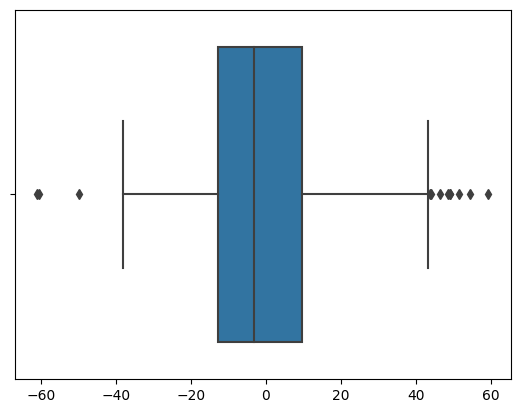

In [6]:
# Plot the residuals
sns.boxplot(x=residuals)
plt.show()

Residuals mean: 3.696222310160915e-14
Residuals std: 20.2419895126205
Number of outliers for std test : 1


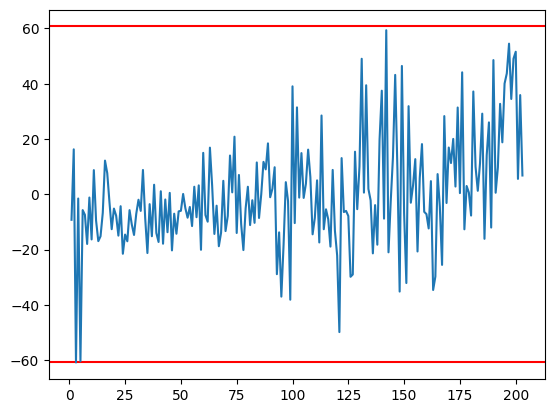

In [7]:
## Find the outliers using 3 standard deviations from the mean
Rmean = residuals.mean()
Rstd = residuals.std()
print("Residuals mean:", Rmean)
print("Residuals std:", Rstd)

Routliers_std = residuals[(residuals < Rmean - 3*Rstd) | (residuals > Rmean + 3*Rstd)]
print("Number of outliers for std test :", len(Routliers_std))

# Plot the time series of residuals
plt.axhline(y=3*Rstd, color='r', linestyle='-')
plt.axhline(y=-3*Rstd, color='r', linestyle='-')
plt.plot(residuals)
plt.show()


## Autocorrelation of Residuals

In [8]:
# fit the time series regression model
modelAR = sm.tsa.SARIMAX(residuals, order=(1,1,1)) 
resultsAR = modelAR.fit()

# calculate the Durbin-Watson statistic
dw_stat = sm.stats.durbin_watson(resultsAR.resid)
print("Durbin-Watson statistic: ", dw_stat)

Durbin-Watson statistic:  1.9812365490254897


In [9]:
from scipy.stats import shapiro

# perform the Shapiro-Wilk test
statSh, pSh = shapiro(resultsAR.resid)
print("Shapiro-Wilk test statistic: ", statSh)
print("Shapiro-Wilk test p-value: ", pSh)

Shapiro-Wilk test statistic:  0.9915707111358643
Shapiro-Wilk test p-value:  0.28859448432922363


In [10]:
# import statsmodels.stats.stattools

# from statsmodels.stats.stattools import durbin_watson_test

# # perform the Durbin-Watson test
# dw_stat, p_value, _, _ = durbin_watson_test(resultsAR.resid)

# print("Durbin-Watson test statistic: ", dw_stat)
# print("Durbin-Watson test p-value: ", p_value)

## Bootstrapping of Standard Errors

In [11]:
# get the original coefficients and standard errors
original_coefs = model.params
original_se = model.bse

print(model.params)
print(model.bse)

# set the number of bootstrap samples
N_BOOT = 10_000

# initialize empty arrays to store the bootstrapped coefficients and standard errors
boot_coefs = np.zeros((N_BOOT, len(model.params)))
boot_se = np.zeros((N_BOOT, len(model.params)))

# perform the bootstrap
for i in range(N_BOOT):
    # create a bootstrap sample
    sample_index = np.random.randint(1, len(X), len(X))
    X_boot = X.loc[sample_index]
    y_boot = Y.loc[sample_index]
    
    # fit the linear regression model on the bootstrap sample
    reg_boot = sm.OLS(y_boot, X_boot).fit()
    
    # store the bootstrapped coefficients and standard errors
    boot_coefs[i] = reg_boot.params
    boot_se[i] = reg_boot.bse

# calculate the mean and standard deviation of the bootstrapped coefficients and standard errors
mean_coefs = np.mean(boot_coefs, axis=0)
std_coefs = np.std(boot_coefs, axis=0)
mean_se = np.mean(boot_se, axis=0)
std_se = np.std(boot_se, axis=0)

print("mean_coefs :",mean_coefs)
print("std_coefs :",std_coefs)
print("mean_se :",mean_se)
print("std_se :",std_se)

const      16.284764
d_dpi       0.355667
d_unemp   -16.014886
dtype: float64
const      1.910841
d_dpi      0.047779
d_unemp    3.792157
dtype: float64
mean_coefs : [ 16.24878437   0.35578027 -16.01046552]
std_coefs : [2.31764079 0.05664948 4.2148152 ]
mean_se : [1.90612671 0.04814723 3.81654753]
std_se : [0.13413187 0.00460141 0.37180237]


## Performance Testing

<AxesSubplot: xlabel='Explained', ylabel='Predicted'>

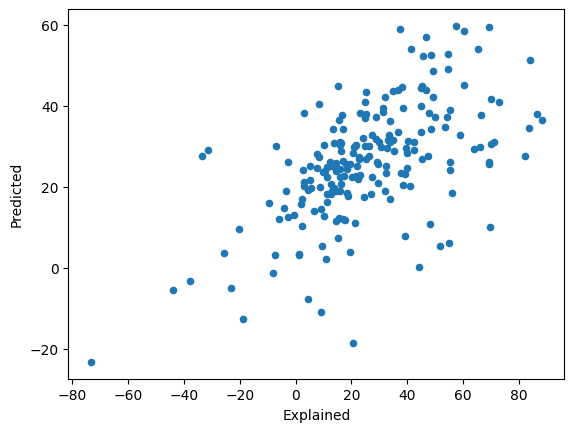

In [12]:
# Scatter plot of d_consumption and it's predicted value
Data3residuals.plot.scatter(x='Explained', y='Predicted')

In [13]:
## Fit the regression model of the Predicted over the Explained variables
# Create the independent and dependent variables for the regression
Xsc = Data3residuals["Predicted"]
Ysc = Data3residuals["Explained"]

# Add a constant term to the independent variables
Xsc = sm.add_constant(Xsc)

# Fit the regression model
modelsc = sm.OLS(Ysc, Xsc).fit()

# Print the summary of the model
print(modelsc.summary())

                            OLS Regression Results                            
Dep. Variable:              Explained   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     101.1
Date:                Mon, 30 Jan 2023   Prob (F-statistic):           1.57e-19
Time:                        16:37:07   Log-Likelihood:                -898.12
No. Observations:                 203   AIC:                             1800.
Df Residuals:                     201   BIC:                             1807.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.046e-13      2.954   3.54e-14      1.0